In [2]:
import matplotlib.pyplot as plt
import os
import json
import sys
from cycler import cycler
import re
from statistics import mean, median
import random
import numpy as np

Now processing architecture  frankencerts ...
Now processing model  frankencerts-v1-1M ...
Now processing model  frankencerts-v1 ...
Now processing architecture  v3 ...
Now processing model  balanced-versions ...
Now processing model  zmap-data-custom ...
Now processing model  2022-scanned-custom ...
Now processing model  zmap-data ...
Now processing model  2022-scanned-1024-3-0.0002lr-0.1dropout-epoch3-step300000 ...
Now processing model  balanced-versions-custom ...
Now processing model  balanced-versions-1024-3-0.0002lr-0.1dropout-epoch3-step300000 ...
Now processing model  zmap-data-256-3-0.0002lr-0.1dropout-epoch3-step300000 ...
Now processing model  zmap-data-1024-3-0.0002lr-0.1dropout-epoch3-step300000 ...
Count of result files used 97255
24


/tmp/ipykernel_1603313/2750259599.py:91: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-x" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([x[-1], len(unique_discrepancies)], [y[-1], len(all_results)], "-x", color='grey', linestyle='dashed', markersize=14)


Now processing model  2022-scanned ...
Now processing model  2022-scanned-256-3-0.0002lr-0.1dropout-epoch3-step300000 ...
Now processing model  balanced-versions-256-3-0.0002lr-0.1dropout-epoch3-step300000 ...
Now processing architecture  v3-experiments-extra ...
Now processing model  zmap-data-1024-3-0.0002lr-0.1dropout-epoch3-step300000T1.5 ...
Now processing architecture  v3-experiments ...
Now processing model  zmap-data-1024-3-0.0002lr-0.1dropout-epoch3-step300000T1.75 ...
Now processing model  zmap-data-1024-3-0.0002lr-0.1dropout-epoch3-step300000T3 ...
Now processing model  zmap-data-1024-3-0.0002lr-0.1dropout-epoch3-step300000T1.5 ...
Now processing model  zmap-data-1024-3-0.0002lr-0.1dropout-epoch3-step300000T1 ...
Now processing model  zmap-data-1024-3-0.0002lr-0.1dropout-epoch3-step300000T0.75 ...
Now processing model  zmap-data-1024-3-0.0002lr-0.1dropout-epoch3-step300000T1.25 ...
Now processing model  zmap-data-1024-3-0.0002lr-0.1dropout-epoch3-step300000T0.5 ...
Now proce

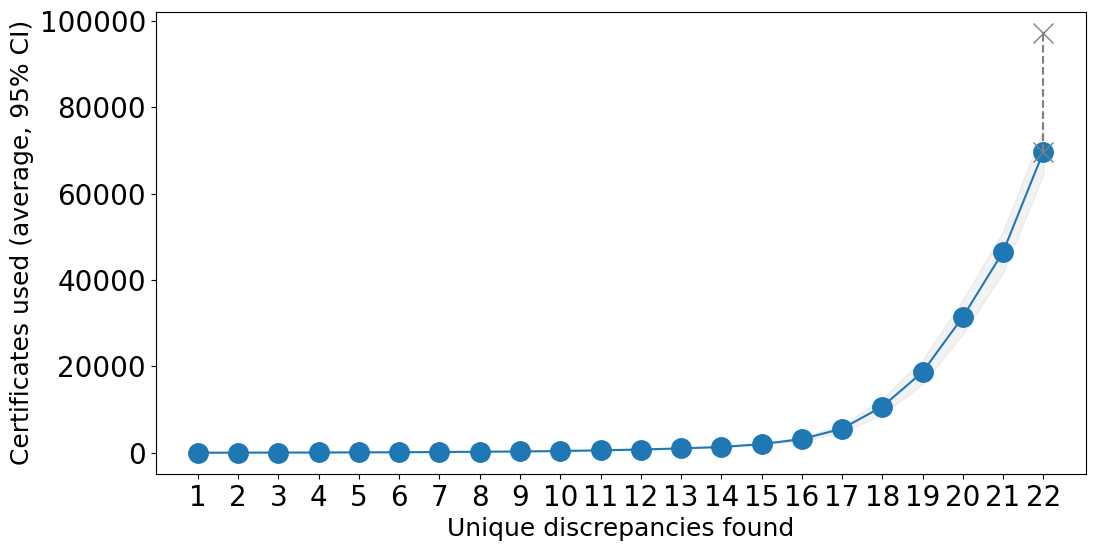

In [5]:
# To help with labels
labels_translation = {"v3/2022-scanned": "2022/GPT-Finetuned",
                     "v3/2022-scanned-1024-3-0.0002lr-0.1dropout-epoch3-step300000": "2022/RNN-Medium",
                     "v3/2022-scanned-256-3-0.0002lr-0.1dropout-epoch3-step300000": "2022/RNN-Small",
                     "v3/2022-scanned-custom": "2022/GPT",
                     
                     "v3/balanced-versions": "Balanced/GPT-Finetuned",
                     "v3/balanced-versions-1024-3-0.0002lr-0.1dropout-epoch3-step300000": "Balanced/RNN-Medium",
                     "v3/balanced-versions-256-3-0.0002lr-0.1dropout-epoch3-step300000": "Balanced/RNN-Small",
                     "v3/balanced-versions-custom": "Balanced/GPT",
                      
                     "v3/zmap-data": "IPv4/GPT-Finetuned",
                     "v3/zmap-data-1024-3-0.0002lr-0.1dropout-epoch3-step300000": "IPv4/RNN-Medium",
                     "v3/zmap-data-256-3-0.0002lr-0.1dropout-epoch3-step300000": "IPv4/RNN-Small",
                     "v3/zmap-data-custom": "IPv4/GPT",
                      
                     "frankencerts/frankencerts-v1": "PriorWork/Frankencerts",
                     "zmapOriginalCerts/zmapOriginalCerts": "TrainingDataset/IPv4"
                     }

# Show relationship b/w no. of MLcerts with unique discrepancies found
results_dir = "/home/XYZ/docker/attached_dir/all_results/testing-results"
code_coverage_dir = "/home/XYZ/docker/attached_dir/all_results/coverage"

# Iterate through results, ignoring 00000 or 11111, and only including discrepancies (i.e., 11011)
fig = plt.figure(figsize=(12, 6))
for arch_dir in os.listdir(results_dir):
    print("Now processing architecture ", arch_dir, "...")
    
    #if arch_dir != "V3" or "V3-EXPERIMENTS" in arch_dir:
    #    continue

    for dir in os.listdir(results_dir + "/" + arch_dir):
        print("Now processing model ", dir, "...")
        
        # for paper rebuttal
        # if not ((dir == "zmap-data-1024-3-0.0002lr-0.1dropout-epoch3-step300000" and arch_dir == "V3" and True) or ("T1.5-LARGE-LARGE" in dir and arch_dir == "V3-EXPERIMENTS" and False)):
        #     continue
        
        # original
        if not ((dir == "zmap-data-1024-3-0.0002lr-0.1dropout-epoch3-step300000" and arch_dir == "v3" and True) or ("T1.5-LARGE-LARGE" in dir and arch_dir == "V3-EXPERIMENTS" and False)):
            continue
            
        all_results = []
#         models_disc[arch_dir + "/" + dir] = []
        count = 0
        for f in os.listdir(results_dir + "/" + arch_dir + "/" + dir + "/json/"):
            if ".json" in f:
                count += 1
                with open(results_dir + "/" + arch_dir + "/" + dir + "/json/" + f) as oF:
                    data = json.load(oF)
                    this_pattern = ""
                    for elem in data:
                        this_pattern += str((int(data[elem] != 0)))
                    all_results.append(this_pattern)
    
        print("Count of result files used", count)
        print(len(set(all_results)))
        if len(set(all_results)) < 2:
            print("Skipping...", dir, " due to too dew disc...")
            continue

        findings = {}
        x = []
        y = []
        err = []
        for i in range(0, 50):
            unique_discrepancies = set()
            random.shuffle(all_results)
            for i in range(0, len(all_results)):
                # We only care about outputs that indicate a discrepancy
                if (all_results[i] == '00000' or all_results[i] == '11111'):
                    continue 

                if all_results[i] not in unique_discrepancies:
                    unique_discrepancies.add(all_results[i])
                    
                    if len(unique_discrepancies) not in findings:
                        findings[len(unique_discrepancies)] = []
                    
                    findings[len(unique_discrepancies)].append(i+1)
        
        for i in findings:
            x.append(i)
            y.append(np.mean(findings[i])) 
            
            ci = 1.96 * np.std(findings[i])/np.sqrt(len(findings[i]))
            err.append(ci)
        
        plt.plot(x, y, "-o", label=labels_translation["v3/" + dir], markersize=14)
        plt.plot([x[-1], len(unique_discrepancies)], [y[-1], len(all_results)], "-x", color='grey', linestyle='dashed', markersize=14)
        plt.fill_between(x, np.subtract(y, err), np.add(y, err), color='grey', alpha=.1)

        
SMALL_SIZE = 16
MEDIUM_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE-2)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE+2)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE+2)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
        
plt.xlabel("Unique discrepancies found")
ax = plt.gca()
#ax.hlines(y=20000, xmin=1, xmax=18, linewidth=2, color='r')
#plt.yscale("log")
#ax.set_ylim([0, 100000])
#plt.yticks([0, 10, 100, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000])
plt.xticks([*range(1, 23)])
plt.ylabel("Certificates used (average, 95% CI)")
#plt.legend(fontsize=18)

plt.savefig('/home/XYZ/notebook/MLcertsJupyter/Figures/certCount.pdf', bbox_inches='tight')